# Advanced EDA
Notebook performs an EDA on the combined masks as well as the seperated masks as provided in the raw dataset.

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

## Averaging masks
Getting an average of all masks.<br />
This gives a frequency map of the times a pixel is activated in the dataset, or in other words gives an idea of the frequency of masks of certein orientation or of certein features.

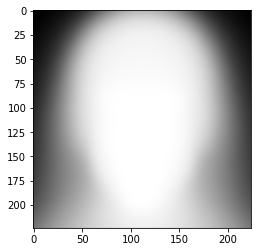

In [2]:
ann_path = "../data/processed/CelebAMask-HQ/mask/"
masks = []
for f in os.listdir(ann_path):
    path = os.path.join(ann_path, f)
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    masks.append(mask)
masks = np.asarray(masks)
avg_mask = np.mean(masks, axis=0)
avg_mask = np.reshape(avg_mask, (224, 224))
avg_mask.astype(np.uint8)
plt.imshow(avg_mask, 'gray')

In [3]:
with open("../reports/performance_data/avg_mask.txt", "wb") as fp:
    pickle.dump(avg_mask, fp)

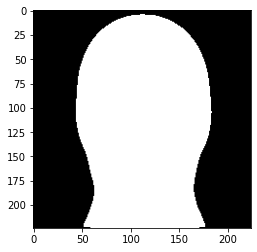

In [4]:
_, thresh1 = cv2.threshold(avg_mask,200,255,cv2.THRESH_BINARY)
plt.imshow(thresh1, 'gray')

### Orientation
From `thresh1` it can be infered that in a majority of the images the subject is facing forward with little or no tilt.<br />
To counter this, random rotation and flip transforms are applied on masks and images, this would ensure that the model does not overly focus on the central locations of the image. This is especially required since as seen in `avg_mask` the masks mostly are concentrated in the central region and completely absent in top-left or top-right sections of the image.

In [5]:
centre = avg_mask[125, 125]
periphery = (avg_mask[175, 40]+avg_mask[175, 180])/2
print("Central pixel value : ", centre)
print("Peripheral pixel value : ", periphery)

Central pixel value :  254.9915
Peripheral pixel value :  158.63011666666665


In [6]:
print("Periphery % : ", periphery/centre * 100)

Periphery % :  62.20996255430736


As seen above, only ~62% of masks extend to the periphery or are present in the periphery, i.e. ~40% of the images have people positioned at the center, whereas remaining images include cases where people are present in the periphery or where the hair extends toward the periphery, or face is oriented toward the periphery.

## Averaging Seperated Masks
Now, we average all the seperated masks as given in the raw dataset, they can be portrayed in a colour coded format in a single image. This can help gauging frequency of different positions and orientations of the face.

In [7]:
ann_path = "../data/interim/CelebAMask-HQ/mask/"
categories = [
    'hair.png',
    'neck.png',
    'skin.png',
    'nose.png'
]

In [8]:
hair = np.zeros((512, 512))
neck = np.zeros((512, 512))
skin = np.zeros((512, 512))
nose = np.zeros((512, 512))
#dataset size -> 30,000
for i in range(30000):
    f = "{:05d}".format(i)
    for cat in categories:
        path = ann_path + f + '_' + cat
        if not os.path.exists(path):
            continue
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)/255
        if cat=='hair.png':
            hair += img
        if cat=='neck.png':
            neck += img
        if cat=='skin.png':
            skin += img
        if cat=='nose.png':
            nose += img
# Averaging over all images in dataset
hair = hair/30000 * 255
neck = neck/30000 * 255
skin = skin/30000 * 255
nose = nose/30000 * 255
hair = np.asarray(hair)
neck = np.asarray(neck)
skin = np.asarray(skin)
nose = np.asarray(nose)
# Converting to range [0, 255]
hair.astype(np.uint8)
neck.astype(np.uint8)
skin.astype(np.uint8)
nose.astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

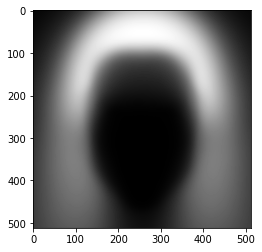

In [9]:
plt.imshow(hair, 'gray')

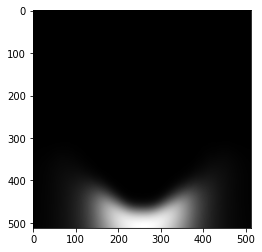

In [10]:
plt.imshow(neck, 'gray')

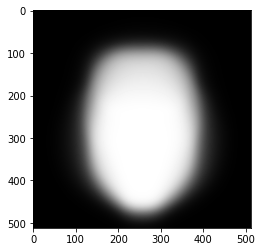

In [11]:
plt.imshow(skin, 'gray')

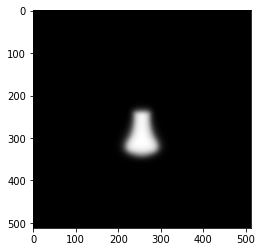

In [12]:
plt.imshow(nose, 'gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


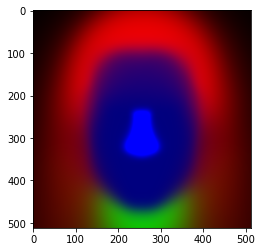

In [19]:
seperated_map = np.zeros((512, 512, 3))
seperated_map[:, :, 0] = hair
seperated_map[:, :, 1] = neck
seperated_map[:, :, 2] = skin/2 + nose
plt.imshow(seperated_map)

The `seperated_map` gives a clear picture of the split up of the area of mask taken by hair, neck and skin(face). Hence, it can be added to the conclusion of `combined_avg_mask` that all the faces are oriented at the center of the picture, and can be seen that most of the peripheral masks are due to the subjects hair and not due to subject being present at the periphery. Also, the confinement of the nose mask at the exact center of the mask frame, reinforces the previous conclusion that the subjects are oriented facing the camera. <br />
From previous calculation of *periphery%* it can be observed that ~60% of subjects in dataset, at a minimum have longer hair, which is quite well balanced.
Due to the skewing of the dataset, it becomes necessary to introduce random transforms into the dataset.

<hr>

### Random PyTorch transforms
To apply torchvision random transforms, with a same seed on both mask and image transforms, in order to maintain the orientation between images and their respective masks.

In [11]:
import torchvision
import random
from PIL import Image

In [12]:
sample_path_ann = "../data/raw/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/00011_"
sample_path = "../data/raw/CelebAMask-HQ/CelebA-HQ-img/11.jpg"
categories = [
    'hair.png',
    'l_brow.png',
    'r_brow.png',
    'l_eye.png',
    'r_eye.png',
    'nose.png',
    'l_lip.png',
    'u_lip.png',
    'neck.png',
    'skin.png',
    'mouth.png',
    'l_ear.png',
    'r_ear.png',
    'cloth.png'
]

In [13]:
def get_combined_ann(root, categories):
    combined_ann = np.zeros((512, 512)).astype(np.uint8)
    for cat in categories:
        path = root + cat
        if not os.path.exists(path):
            continue
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        combined_ann = cv2.add(combined_ann, img)
    return combined_ann

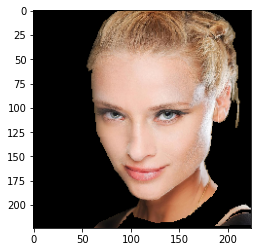

In [14]:
img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = cv2.resize(img, (224, 224))
combined_ann = get_combined_ann(sample_path_ann, categories)
combined_ann = cv2.resize(combined_ann, (224, 224))
img = Image.fromarray(img)
mask = Image.fromarray(combined_ann)
mask = mask.convert('L')#ImageOps.grayscale(mask)
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    torchvision.transforms.RandomRotation(45),
    torchvision.transforms.RandomVerticalFlip(p=0.2)
])
seed = np.random.randint(2147483647)
random.seed(seed)
img = np.asarray(transform(img))
random.seed(seed)
mask = np.asarray(transform(mask))
portrait = cv2.bitwise_and(img, img, mask = mask)
plt.imshow(portrait)

The above code has been implemented in the training module : `model_select.py` <br />
<hr>